In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats

In [2]:
df = pd.read_csv('data/protein.csv')

In [3]:
id_col = df['ID']

In [4]:
df = df.drop(labels=['ID'], axis=1)

In [5]:
df.dtypes

protein_1     float64
protein_2     float64
protein_3     float64
protein_4     float64
protein_5     float64
protein_6     float64
protein_7     float64
protein_8     float64
protein_9     float64
protein_10    float64
dtype: object

In [6]:
class OutlierClipper:
    def __init__(self, features, threshold = 1.5):
        self.threshold = threshold
        self._features = features
        self._feature_map = {}

    def fit(self, X, **kwargs):
        df = X[self._features]
        features = list(df.columns)
        for feature in features:
            # f_q1 = df[feature].quantile(0.25)
            # f_q3 = df[feature].quantile(0.75)
            # f_iqr = f_q3 - f_q1

            mean = X[feature].mean()
            std = X[feature].std(ddof=0)
            
            self._feature_map[feature] = (mean - (self.threshold * std), mean + (self.threshold * std))
        return self
    
    def count_outliers(self, data):
        for column in data.columns:
            too_low = sum(data[column] < self._feature_map[column][0])
            too_high = sum(data[column] > self._feature_map[column][1])
            print('Column {} has {} high values and {} low values. overall: {}'.format(column, too_high, too_low, too_high + too_low))

    def transform(self, data):
        data_copy = data.copy()
        for feature in self._feature_map.keys():
            data_copy[feature] = data_copy[feature].clip(lower=self._feature_map[feature][0],
                                                         upper=self._feature_map[feature][1])
        return data_copy

    def fit_transform(self, X, **kwargs):
        self.fit(X, y, **kwargs)
        return self.transform(X)

In [7]:
outlier_clipper = OutlierClipper(df.columns, threshold=1)
outlier_clipper.fit(df)
df = outlier_clipper.transform(df)

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


class Imputer:
    def __init__(self):
        self.iterative_imputer = IterativeImputer(initial_strategy='mean')

    def fit(self, X, **kargs):
        self.iterative_imputer.fit(X)
        # print(X.shape)
        return self

    def transform(self, X):
        columns = X.columns
        X = self.iterative_imputer.transform(X)
        X = pd.DataFrame(X, columns=columns)
        return X

    def fit_transform(self, X, **kwargs):
        self.fit(X, y, **kwargs)
        return self.transform(X)

In [9]:
imputer = Imputer()
imputer.fit(df)
df = imputer.transform(df)
df.isna().sum()

protein_1     0
protein_2     0
protein_3     0
protein_4     0
protein_5     0
protein_6     0
protein_7     0
protein_8     0
protein_9     0
protein_10    0
dtype: int64

In [10]:
df.describe()

,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,protein_10
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,-0.113080,-0.178289,0.054462,1.054271,0.081684,-0.168656,0.056921,-0.045867,-0.107584,0.033990
std,1.610126,2.900357,1.637812,3.454395,2.320824,2.546993,1.587216,1.144313,2.262344,0.857679
min,-6.988484,-21.059248,-8.281800,-15.793730,-3.439964,-11.080775,-5.325755,-4.606367,-14.695770,-1.514069
25%,-1.000435,-0.908684,-0.649152,-2.044648,-1.663794,-1.690087,-0.783157,-0.769140,-1.002541,-0.619832
50%,-0.303210,-0.213589,0.095605,1.640231,-0.303521,-0.625816,-0.100479,-0.083797,0.031503,0.039066
75%,0.540866,0.465710,0.811024,3.448381,2.140752,1.125899,0.722525,0.645523,0.835537,0.628403
max,6.064229,18.711459,7.827003,18.724884,3.689852,9.595209,6.049897,4.206154,12.848736,1.807004


In [61]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, make_scorer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, cross_val_score

kmeans = KMeans(n_clusters=5, random_state=0)

spectral = SpectralClustering(n_clusters=5,
        n_components=6,
        gamma=100,
        assign_labels="discretize",
        random_state=0)

gmm_param_grid = dict(covariance_type=['full', 'diag', 'tied', 'spherical'], tol=np.logspace(-10, -1, 10), reg_covar=np.logspace(-10, -1, 10))

gmm_grid = GridSearchCV(estimator=GaussianMixture(n_components=5, random_state=0), 
                        param_grid=gmm_param_grid,
                        n_jobs=-1)

gmm = GaussianMixture(n_components=5, random_state=0)

gmm_grid.fit(df)
print(gmm_grid.best_score_, gmm_grid.best_params_)

kmeans.fit(df)
spectral.fit(df)
gmm.fit(df)




-17.739907305917498 {'covariance_type': 'diag', 'reg_covar': 1e-05, 'tol': 1e-10}


GaussianMixture(n_components=5, random_state=0)

In [63]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

print(f'KMEANS davies_boulding: {davies_bouldin_score(df, kmeans.labels_)}')
print(f'SPECTRAL davies_boulding: {davies_bouldin_score(df, spectral.labels_)}')
print(f'GNN davies_boulding: {davies_bouldin_score(df, gmm.predict(df))}')
print(f'GNN_grid davies_boulding: {davies_bouldin_score(df, gmm_grid.predict(df))}')

print('------------------------------------')

print(f'KMEANS silhouette_score: {silhouette_score(df, kmeans.labels_)}')
print(f'SPECTRAL silhouette_score: {silhouette_score(df, spectral.labels_)}')
print(f'GNN silhouette_score: {silhouette_score(df, gmm.predict(df))}')
print(f'GNN_grid silhouette_score: {silhouette_score(df, gmm_grid.predict(df))}')

KMEANS davies_boulding: 1.3377011878474463
SPECTRAL davies_boulding: 12.33590789608277
GNN davies_boulding: 2.7426192276224417
GNN_grid davies_boulding: 4.399281766832332
------------------------------------
KMEANS silhouette_score: 0.2562171490476342
SPECTRAL silhouette_score: -0.14184249054478745
GNN silhouette_score: 0.19563290895136004
GNN_grid silhouette_score: 0.19470794467988634


In [13]:
result = pd.DataFrame()
result['ID'] = id_col
result['y'] = kmeans.labels_

result.to_csv(f'results/kmeans_clusters.csv', index=False)

result = pd.DataFrame()
result['ID'] = id_col
result['y'] = spectral.labels_

result.to_csv(f'results/spectral_clusters.csv', index=False)


result = pd.DataFrame()
result['ID'] = id_col
result['y'] = gmm.predict(df)

result.to_csv(f'results/gmm_clusters.csv', index=False)

In [78]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

def reduce_dims_and_plot_2d(X, y, centers):
    

    pca = PCA(n_components=3)

    X_hat = pca.fit_transform(X)

    centers_hat = pca.transform(centers)

    reduced = pd.DataFrame()
    reduced['pca-one'] = X_hat[:,0]
    reduced['pca-two'] = X_hat[:,1]
    reduced['pca-three'] = X_hat[:,2]
    reduced['y'] = y

    centers_reduced = pd.DataFrame()
    centers_reduced['pca-one'] = centers_hat[:,0]
    centers_reduced['pca-two'] = centers_hat[:,1]
    centers_reduced['pca-three'] = centers_hat[:,2]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette="deep",
        data=reduced,
        legend="full",
    )
    plt.scatter(centers_reduced['pca-one'], centers_reduced['pca-two'], marker='o',
                c="white", alpha=1, s=200, edgecolor='k'
    )

def reduce_dims_and_plot_3d(X, y, centers):
    reduced = pd.DataFrame()

    pca = PCA(n_components=3)

    X_hat = pca.fit_transform(X)

    centers_hat = pca.transform(centers)

    reduced['pca-one'] = X_hat[:,0]
    reduced['pca-two'] = X_hat[:,1]
    reduced['pca-three'] = X_hat[:,2]
    reduced['y'] = y

    centers_reduced = pd.DataFrame()
    centers_reduced['pca-one'] = centers_hat[:,0]
    centers_reduced['pca-two'] = centers_hat[:,1]
    centers_reduced['pca-three'] = centers_hat[:,2]

    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=reduced["pca-one"], 
        ys=reduced["pca-two"], 
        zs=reduced["pca-three"], 
        c=reduced["y"], 
        cmap='tab10'
    )
    ax.scatter(
        xs=centers_reduced["pca-one"], 
        ys=centers_reduced["pca-two"], 
        zs=centers_reduced["pca-three"],
        marker='o', c="white", alpha=1, s=200, edgecolor='k'
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()

In [52]:
model = kmeans


array([[-3.45242779e-01, -1.72074435e-01, -1.36796494e-01,
         1.99511537e+00,  3.18030254e+00, -1.28629029e+00,
        -2.16284128e-01, -5.35915475e-01,  7.65483077e-01,
        -3.04138179e-01],
       [-1.43918742e-01, -3.28509589e-01, -2.14697604e-01,
        -8.48276116e-01, -3.67449870e-01,  2.97592030e+00,
        -2.74898471e-01,  1.62207569e-02, -3.53968042e-02,
        -1.55874648e-02],
       [ 3.21526896e-01,  1.47758402e-01,  2.07724762e-01,
         4.51001810e+00, -1.35842478e+00, -5.46429268e-01,
         3.64489042e-01,  3.92769314e-01, -1.23464772e+00,
         4.60089231e-01],
       [ 5.18349103e-01, -2.10516823e+01, -6.36873535e-01,
         8.14282522e-01, -1.25183139e+00, -2.78712981e+00,
         7.11844087e-01,  5.32488164e-01, -3.36427472e-01,
         1.21440032e-01],
       [-4.79988378e-01,  5.80933865e-01,  4.35273639e-01,
        -3.16352725e+00, -1.09161435e+00, -1.88865271e+00,
         3.12490865e-01, -1.95666212e-01,  4.27342848e-01,
        -1.

In [74]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

kmeans_centroids_clf = NearestCentroid()
kmeans_centroids_clf.fit(df, kmeans.predict(df))
kmeans_centroids = kmeans_centroids_clf.centroids_

spectral_centroids_clf = NearestCentroid()
spectral_centroids_clf.fit(df, spectral.labels_)
spectral_centroids = spectral_centroids_clf.centroids_

gmm_centroids_clf = NearestCentroid()
gmm_centroids_clf.fit(df, gmm.predict(df))
gmm_centroids = gmm_centroids_clf.centroids_



2    149
0    125
1    119
4     96
3      5
Name: y, dtype: int64


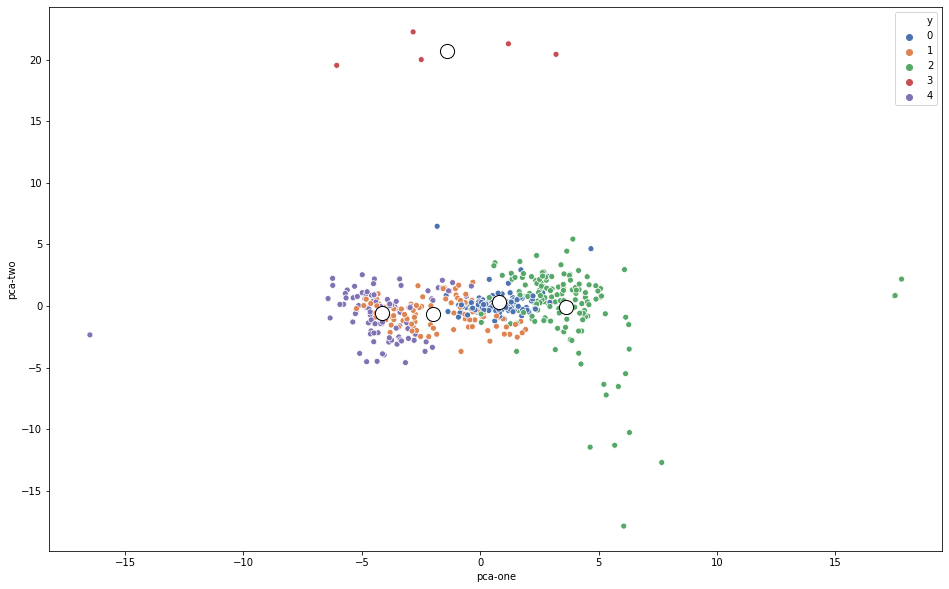

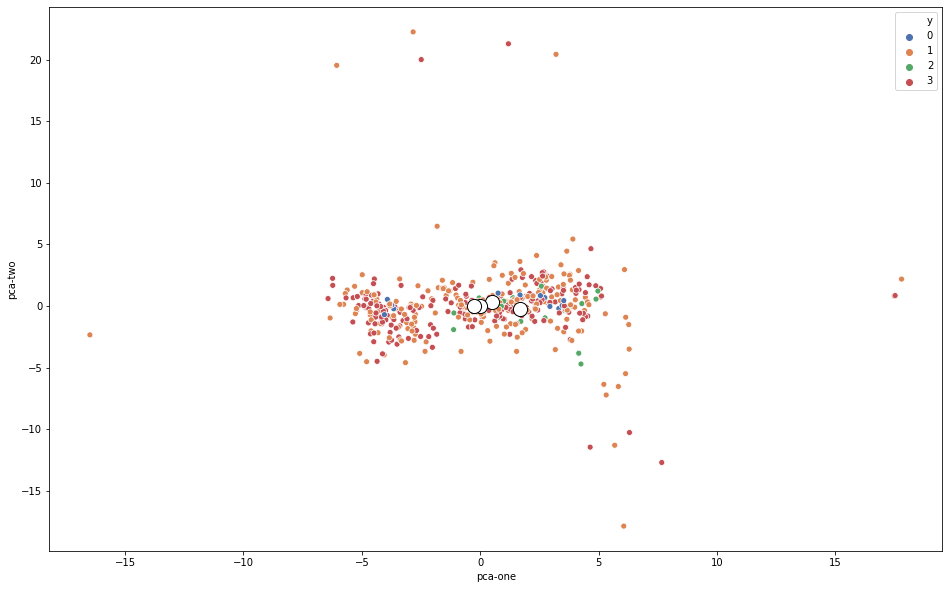

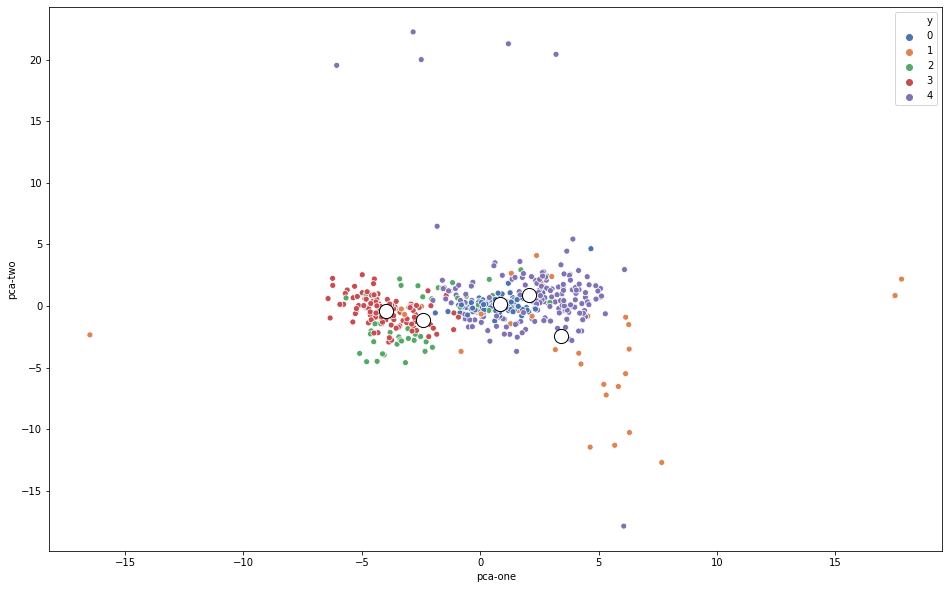

In [75]:
t = pd.DataFrame()
t["y"] = kmeans.labels_
print(t["y"].value_counts())

reduce_dims_and_plot_2d(df, kmeans.labels_, kmeans_centroids)

reduce_dims_and_plot_2d(df, spectral.labels_, spectral_centroids)

reduce_dims_and_plot_2d(df, gmm.predict(df), gmm_centroids)

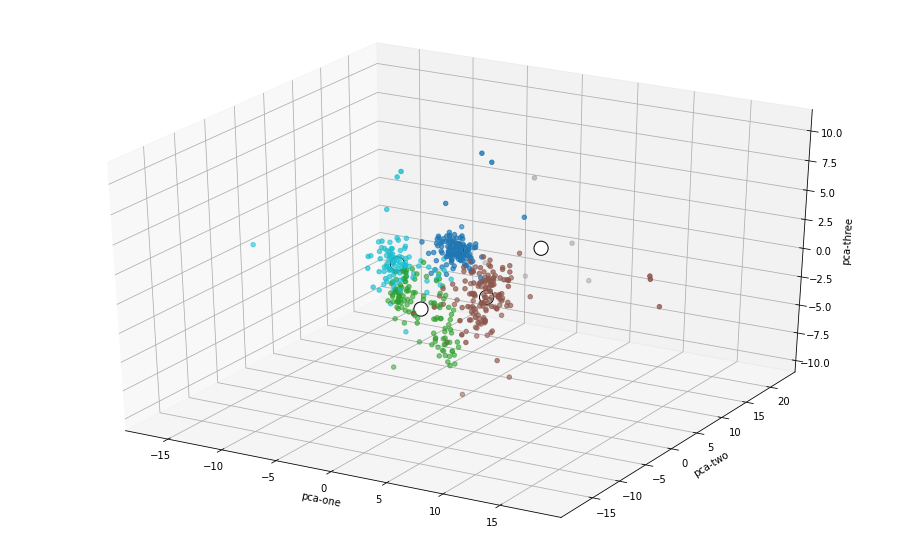

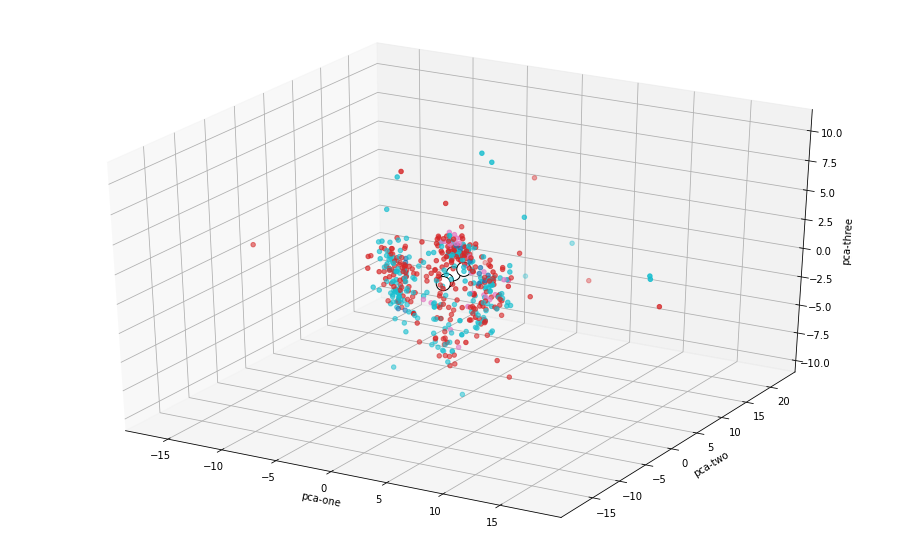

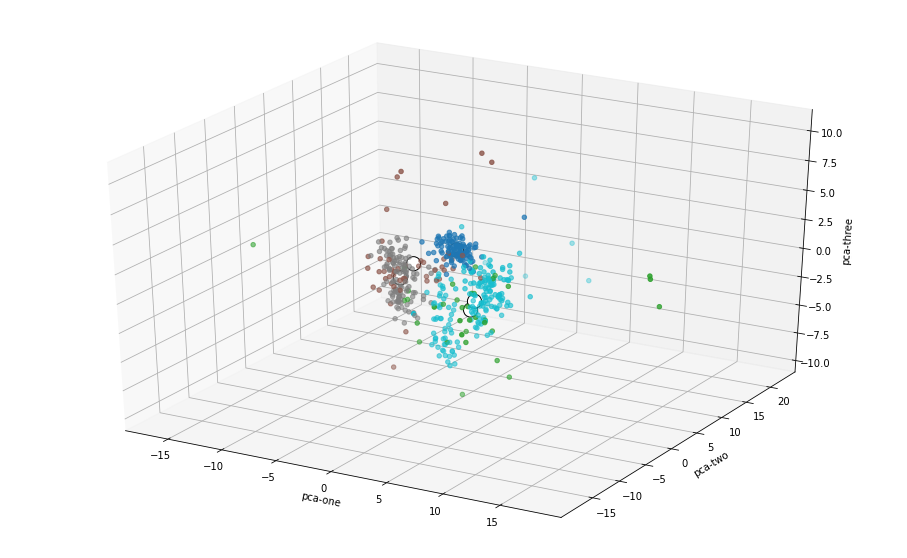

In [80]:
reduce_dims_and_plot_3d(df, kmeans.labels_, kmeans_centroids)

reduce_dims_and_plot_3d(df, spectral.labels_, spectral_centroids)

reduce_dims_and_plot_3d(df, gmm.predict(df), gmm_centroids)

# Mutations Characteristics

## Mutation Prevelence

In [87]:
df_labeled = pd.DataFrame(df)
df_labeled['y'] = kmeans.labels_
df_labeled.y.value_counts(normalize=True)

2    0.301619
0    0.253036
1    0.240891
4    0.194332
3    0.010121
Name: y, dtype: float64

## Mutation Centroids

In [88]:
kmeans_centroids

array([[-3.45242779e-01, -1.72074435e-01, -1.36796494e-01,
         1.99511537e+00,  3.18030254e+00, -1.28629029e+00,
        -2.16284128e-01, -5.35915475e-01,  7.65483077e-01,
        -3.04138179e-01],
       [-1.43918742e-01, -3.28509589e-01, -2.14697604e-01,
        -8.48276116e-01, -3.67449870e-01,  2.97592030e+00,
        -2.74898471e-01,  1.62207569e-02, -3.53968042e-02,
        -1.55874648e-02],
       [ 3.21526896e-01,  1.47758402e-01,  2.07724762e-01,
         4.51001810e+00, -1.35842478e+00, -5.46429268e-01,
         3.64489042e-01,  3.92769314e-01, -1.23464772e+00,
         4.60089231e-01],
       [ 5.18349103e-01, -2.10516823e+01, -6.36873535e-01,
         8.14282522e-01, -1.25183139e+00, -2.78712981e+00,
         7.11844087e-01,  5.32488164e-01, -3.36427472e-01,
         1.21440032e-01],
       [-4.79988378e-01,  5.80933865e-01,  4.35273639e-01,
        -3.16352725e+00, -1.09161435e+00, -1.88865271e+00,
         3.12490865e-01, -1.95666212e-01,  4.27342848e-01,
        -1.

## Nearest neighbour

In [96]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=5).fit(kmeans_centroids)
distances, indices = nbrs.kneighbors(kmeans_centroids)

print(distances)

[[ 0.          5.82426521  6.31995993  6.83199264 21.53236685]
 [ 0.          5.61502866  6.31995993  6.70352761 21.63735859]
 [ 0.          5.82426521  6.70352761  8.06830127 21.67765196]
 [ 0.         21.53236685 21.63735859 21.67765196 22.09317792]
 [ 0.          5.61502866  6.83199264  8.06830127 22.09317792]]


In [97]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [104]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    # for i in range(num_classes):

    #     # Position of each label at median of data points.

    #     print(np.median(xA[colors == i, :], axis=0))
    #     xtext, ytext = np.median(x[colors == i, :], axis=0)
    #     txt = ax.text(xtext, ytext, str(i), fontsize=24)
    #     txt.set_path_effects([
    #         PathEffects.Stroke(linewidth=5, foreground="w"),
    #         PathEffects.Normal()])
    #     txts.append(txt)

    return f, ax, sc, txts

In [102]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(method='exact', n_components=5, random_state=RS).fit_transform(df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 21.676944971084595 seconds


In [105]:
fashion_scatter(fashion_tsne, kmeans.labels_)


[  0.86643755 -13.977215    -6.5644693   -8.686175     1.311797  ]


ValueError: too many values to unpack (expected 2)